# Time - Series Forecasting with CNN

In [39]:
import numpy as np
import pandas as pd
from numpy import array
import torch
import gc
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt


In [40]:
# Read the train and test data
train_set = pd.read_csv('../data/train.csv')
test_set = pd.read_csv('../data/test.csv')

In [41]:
# define a function to get a series of historical data
def split_sequence(sequence, window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_idx = i + window_size

        if end_idx > len(sequence) -1:
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

window_size = 4
train_X, train_y = split_sequence(train_set.iloc[:,1], window_size)
test_X, test_y = split_sequence(test_set.iloc[:,1], window_size)


In [42]:
class ElecDataset(Dataset):
    def __init__(self, feature, target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
        item = self.feature[index]
        label = self.target[index]

        return item, label

In [43]:
class CNN_ForecastNet(nn.Module):
    def __init__(self, window_size):
        super(CNN_ForecastNet, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=window_size, out_channels=64, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64, 50)
        self.fc2 = nn.Linear(50, 1)
        self.float()
    
    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

    

In [44]:
device = torch.device("cpu")
model = CNN_ForecastNet(window_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [45]:
train = ElecDataset(train_X.reshape(train_X.shape[0], train_X.shape[1],1), train_y)
test = ElecDataset(test_X.reshape(test_X.shape[0], test_X.shape[1], 1), test_y)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [46]:
train_losses = []
test_losses = []
label_all = []
pred_all = []

def Train():

    running_loss = .0
    model.train()

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss = loss.float()
        loss.backward()
        optimizer.step()
        running_loss += loss
        

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())

    print(f'train_loss {train_loss}')

def Test():

    running_loss = .0
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds, labels)
            running_loss += loss
            label_all.append(labels.detach().numpy())
            pred_all.append(preds.detach().numpy())

        test_loss = running_loss/len(test_loader)
        test_losses.append(test_loss.detach().numpy())

        print(f'test_loss {test_loss}')

In [47]:
epochs = 50
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1, epochs))
    Train()
    Test()

epochs 1/50
train_loss 0.027325956150889397
test_loss 0.00725557638191384
epochs 2/50
train_loss 0.017115434631705284
test_loss 0.006371690563000056
epochs 3/50
train_loss 0.016410481184720993
test_loss 0.005998172888304623
epochs 4/50
train_loss 0.016037598252296448
test_loss 0.005828311199727217
epochs 5/50
train_loss 0.01578289270401001
test_loss 0.005746198328978048
epochs 6/50
train_loss 0.01555726956576109
test_loss 0.005693136888034899
epochs 7/50
train_loss 0.015357540920376778
test_loss 0.005649645332859349
epochs 8/50
train_loss 0.01519349217414856
test_loss 0.005610876612025873
epochs 9/50
train_loss 0.015071498230099678
test_loss 0.005580676357824766
epochs 10/50
train_loss 0.01499105989933014
test_loss 0.005560106574642753
epochs 11/50
train_loss 0.014936304651200771
test_loss 0.005545272889878832
epochs 12/50
train_loss 0.014893651008605957
test_loss 0.005531181527212668
epochs 13/50
train_loss 0.014857166446745396
test_loss 0.005519012470261388
epochs 14/50
train_loss 0.

In [48]:
print(len(label_all))
print(len(pred_all))

339900
339900


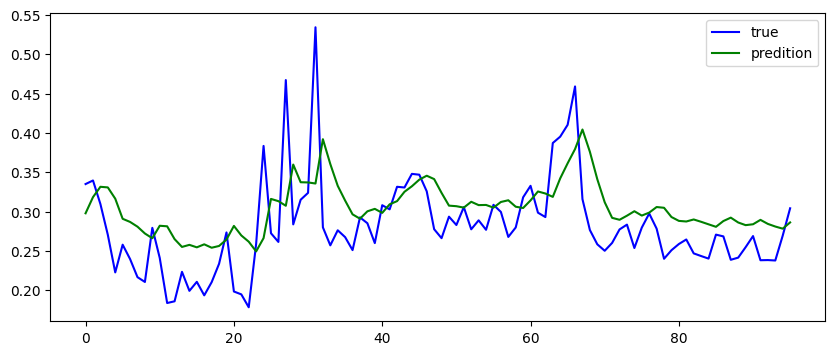

In [49]:
plt.figure(figsize=(10,4))
plt.plot(label_all[:96], color='blue', label='true')
plt.plot(pred_all[:96], color='green', label='predition')
plt.legend()
plt.show()


In [51]:
#torch.save(model.state_dict,{'../saved_models/cnn_w4.pt'})